# Week 4 Lab: You are what you eat (differential expression)

Use this notebook to report your findings from the lab. Lab reports typically should include:
* An introduction giving motivation behind the study, what was done, and summarizing the main findings.
* A methods section providing details on how the analyses were performed.
* A results section providing the main findings.
* A discussion section with interpretation of the results and some leads for future directions.

For this report, we will focus on Methods, Results, and Discussion and have provided some prompts below for these. We have provided an example introduction this week as a reference for future weeks.

**Notes on how to complete the lab report**:

Short answer questions should use Markdown syntax (http://nestacms.com/docs/creating-content/markdown-cheat-sheet). If you would like to include an answer that is a mixture of code and text, you can generate additional cells below the provided answer cell.

You may include Python code to directly generate tables (this can be much easier than copying the numbers to markdown syntax from scratch).

For questions that ask for plots, we prefer you include Python code to generate the results inline. However if you really want to you may also include figures using other means (e.g. making them separately and linking to them in the markdown. or making them in R).

(Now that we're using this report format which will not be autograded, loading files for plotting from your home directory should be fine.)

## Introduction

An introduction should provide:
* motivation for the study
* a brief summary of what was done
* a brief summary of the major results

Diet-induced obesity is known to be a major factor leading to increased risk for a variety of conditions such as heart disease and diabetes. Multiple studies have suggested that diets high in fat content may be contributing to the growing prevalence of obesity and related conditions.

In this study, RNA-sequencing was performed on livers of mice after being fed either a standard Chow diet or a high fat diet (HFD) for seven weeks. We performed differential expression analysis to identify and characterize genes with increased or decreased activity induced by each diet. Overall, we found hundreds of genes showed altered expression levels in the HFD group, suggesting significant diet-induced reprogramming of liver transcription. Differentially expressed genes are highly enriched for involvement in metabolic processes such as lipid processing.

# Methods (20 pts total)

**Dataset description (<font color="red">Methods-Q1</font> - 5 pts)**: Provide a brief description of the six datasets used, including:
* How many samples are you analyzing and where did they come from? (e.g. what species are they, what tissue are you analyzing, what is the difference between the two treatment groups?)
* The number of reads for each sample (i.e. from the original fastqs)
* The read length

We have 6 samples, 3 from mice fed High Fat Diet (HFD) and 3 from mice fed CHOW (control) diet. We're collecting tissue from their livers. 

Number of Reads:

    Chow1 = 70123120/2 = wc -l /datasets/cs185-sp21-A00-public/week4/fastqs/Chow_Rep1.fq / 2 = 35061560
    
    Chow2 = 70340660/2 = 35170330
    
    Chow3 = 64088296/2 = 32044148
    
    HFD1 = 64562596/2 = 32281298
    
    HFD2 = 60862004/2 = 30431002
    
    HFD3 = 45252364/2 = 22626182
    
Read Length = 50    

**Alignment and expression quantification (<font color="red">Methods-Q2</font> - 5 pts)**: Summarize the methods used for aligning RNA-seq reads and quantifying expression for each sample. Include:
* Which tools you used (and when available which version of each tool)
* Which assembly of the reference genome was used?
* Which transcriptome annotation was used?
* Any non-default parameters used for each tool.

We used STAR version 2.7.0f for aligning the reads. We used mouse GRCm38 genome assembly as our reference. We used ENSEMBL Build 75 of our reference genome as our transcriptome annotation. With STAR, we set the --runMode parameter to genomeGenerate to indicate that we're building an index, and then the other parameters to indicate information on our inputs.

We then ran STAR again to actually align our reads to the transcriptome. We used parameters recommended by ENCODE as well as "--outSAMtype BAM SortedByCoordinate" to indicate output format and "--quantMode TranscriptomeSAM" to indicate desired quantification

To quantify expression, we used rsem-prepare-reference (couldn't find version) to preprocess reference transcriptome. Then we used rsem-calculate-expression (couldn't find version) to actually quantify gene expression. These two tools used default parameters (unless -p was used for speed purposes)



**Differential expression analysis (<font color="red">Methods-Q3</font> - 5 pts)**: Summarize the methods used for performing differential expression analysis:

* Which tool(s) did you use for this?
* What preprocessing did you to do the data before running (e.g. loaded with tximport, removed lowly expressed genes)
* What significance value did you use to decide which genes are differentially expressed?

(Note, using the R command `sessionInfo()` will tell you which versions of each package are loaded).

We used DESeq2 to find a set of differentially expressed genes. (version 1.26.0) We used tximport to import rsem results from earlier (version 1.14.2)

We used tximport to load in the rsem results in a way that DSeq could use. We also added a psuedocount to deal with an error with length 0 transcripts. We also filtered out genes with transcript counts less than 10

While I don't think that we have one in the code, I'll propose one that I think might make sense. So 0.05 is a normal threshold, but with 15,464 genes, we would expect 774 false positives. So if we divide 0.05 by 774, this gives a threshold of 6.46e-5, which would mean we only expect 1 false positive under the null distribution.

**Gene enrichment analysis methods (<font color="red">Methods-Q4</font> - 5 pts)**: Summarize the methods you used for performing GO analysis on your differentially expressed genes. (Don't worry if you can't figure out the version of `find_enrichment.py`).

I ran the code below to generate the gene name (sig and all) file for find_enrichment.py, as well as significant when up/down regulated

Then I ran find_enrichment.py as shown in the instructions document for the 3 groups of enriched genes: all, up, down

In [41]:
df = pd.read_csv("chow_vs_hfd_deseq2.csv")
names = pd.read_csv("GRCm38.75.gene_names", sep="\t", names=["Unnamed: 0", "Name"])
df = pd.merge(df, names, on=["Unnamed: 0"])
sig = df[df["padj"] < 0.05]
sig_up = df[df["log2FoldChange"] > 0]
sig_down = df[df["log2FoldChange"] < 0]
with open("sig_genes.txt", "w") as f:
    for gene in sig["Name"]:
        f.write(gene + "\n")
with open("all_genes.txt", "w") as f:
    for gene in df["Name"]:
        f.write(gene + "\n")
with open("sig_up_genes.txt", "w") as f:
    for gene in sig_up["Name"]:
        f.write(gene + "\n")        
with open("sig_down_genes.txt", "w") as f:
    for gene in sig_down["Name"]:
        f.write(gene + "\n")

# Results (45 pts total)

## Summary of expression quantification

**How many genes were expressed (TPM>0) in each sample? (<font color="red">Results-Q1</font> - 3 pts)**

cat Chow_Rep1.genes.results | awk -F " " '{if($5>0)print $5}' | wc -l  #markdown removed dollar signs

Chow1: 16919

Chow2: 17096

Chow3: 16795

HFD1: 17078

HFD2: 16847

HFD3: 16734

**Report the pairwise Pearson correlation between TPM values for each of the six samples (<font color="red">Results-Q2</font> - 5 pts)**: Are replicates strongly correlated with each other? Are replicates of Chow or HFD more strongly correlated than datasets from different treatments (Chow vs. HFD)?

In [48]:
#copied from exmaple in instructions and modified, but I do understand what's going on here
#Also read block quote at bottom for written answer part
import pandas as pd
import numpy as np
import statistics
# Load data for each sample into a pandas data frame
prefixes = ["Chow_Rep1","Chow_Rep2","Chow_Rep3", "HFD_Rep1", "HFD_Rep2", "HFD_Rep3"]
data = pd.read_csv(str(prefixes[0]) + ".genes.results", sep="\t")
data = data[["gene_id", "TPM"]]
data.columns = ["gene_id", prefixes[0]]
for i in range(1, len(prefixes)):
    d = pd.read_csv(str(prefixes[i]) + ".genes.results", sep="\t")
    d = d[["gene_id","TPM"]]
    d.columns = ["gene_id", prefixes[i]]
    data = pd.merge(data, d, on=["gene_id"])

correlations = data[prefixes].corr()
chow_v_chow = []
hfd_v_hfd = []
for i in range(2):
    for j in range(2):
        if i == j:
            continue
        else:
            chow_v_chow.append(correlations.values[i,j])
            hfd_v_hfd.append(correlations.values[i+3,j+3])

chow_v_hfd = correlations.values[0:2, 3:5]

print(statistics.mean(chow_v_chow))
print(statistics.mean(hfd_v_hfd))
print(np.mean(chow_v_hfd))

#README:
responses = """
Replicates are perfectly correlated, naturally (pearson = 1)
The values I've printed above show the average correlation between chow samples and each other, hfd samples and each other,
and chow samples vs hfd samples. What's actually interesting here is that if I remove the diagonal (e.g. Chow1 v Chow1 ; HFD1 v HFD2)
then we see that HFD and Chow are on average more correlated.
I'm not sure, but I think there's definitely an argument to be made that this is correct, since it is sort of a given
that the diagonals will have a value of 1 and don't reflect the reality that our task is to see how different sample
types correlate with themselves and each other.
"""
(data[prefixes].corr())

0.9295300950715684
0.9294449723224609
0.9400902074205789


,Chow_Rep1,Chow_Rep2,Chow_Rep3,HFD_Rep1,HFD_Rep2,HFD_Rep3
Chow_Rep1,1.000000,0.929530,0.973235,0.845316,0.961081,0.949590
Chow_Rep2,0.929530,1.000000,0.980169,0.976229,0.977734,0.974997
Chow_Rep3,0.973235,0.980169,1.000000,0.927043,0.989466,0.970115
HFD_Rep1,0.845316,0.976229,0.927043,1.000000,0.929445,0.950339
HFD_Rep2,0.961081,0.977734,0.989466,0.929445,1.000000,0.964888
HFD_Rep3,0.949590,0.974997,0.970115,0.950339,0.964888,1.000000


**Comparison of replicates (<font color="red">Results-Q3</font> - 7 pts):**  Provide a scatter plot of gene expression values (TPM) in Chow replicates 1 vs. 2 and HFD replicates 1 vs. 2. 

Text(0, 0.5, 'log10 HFD_Rep2')

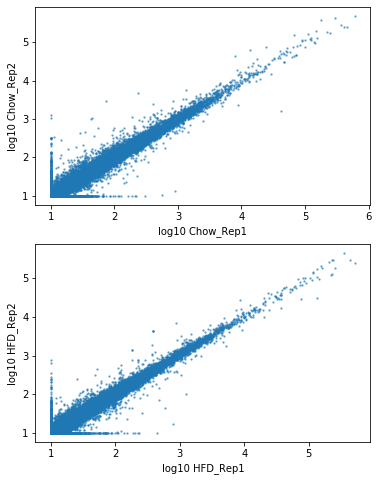

<Figure size 432x288 with 0 Axes>

In [51]:
#Again copies from instructions but I know how to use matplotlib
#Also I'm assuming we want log10 of these, not just the raw numbers
import matplotlib.pyplot as plt
data_log10 = data.copy()
for p in prefixes: 
    data_log10[p] = np.log10(data[p]+1)
fig = plt.figure()
fig.set_size_inches((6, 8))
ax = fig.add_subplot(211)
ax.scatter((data_log10["Chow_Rep1"]+1), (data_log10["Chow_Rep2"]+1), s=2, alpha=0.5)
ax.set_xlabel("log10 Chow_Rep1")
ax.set_ylabel("log10 Chow_Rep2")

fig2 = plt.figure()
fig2.set_size_inches((6, 4))
ax2 = fig.add_subplot(212)
ax2.scatter((data_log10["HFD_Rep1"]+1), (data_log10["HFD_Rep2"]+1), s=2, alpha=0.5)
ax2.set_xlabel("log10 HFD_Rep1")
ax2.set_ylabel("log10 HFD_Rep2")

## Summary of differential gene expression

**Visualization of differentially expressed genes (<font color="red">Results-Q4</font> - 10 pts)**: Provide a "volcano plot" plotting the log2 fold change in gene expression vs. the -log10 p-value for each gene. Color significant genes (FDR<0.05) a different color.

*Extra credit (3 pts)*: Annotate the names of the top 10 differentially expressed genes on the plot. 

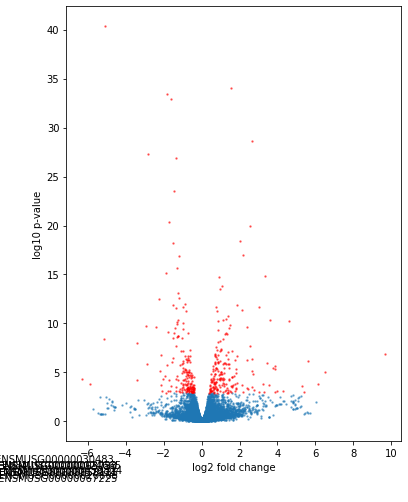

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
df = pd.read_csv("chow_vs_hfd_deseq2.csv")
sig = df[df["padj"] < 0.05]
non_sig = df[df["padj"] >= 0.05]
top_10 = df.sort_values(by="pvalue")[0:9]

fig = plt.figure()
fig.set_size_inches((6, 8))
ax = fig.add_subplot(111)
ax.scatter((non_sig["log2FoldChange"]), (-np.log10(non_sig["pvalue"])), s=2, alpha=0.5)
ax.scatter((sig["log2FoldChange"]), (-np.log10(sig["pvalue"])), s=2, alpha=0.5, color="red")
ax.set_xlabel("log2 fold change")
ax.set_ylabel("log10 p-value")
#currently broken but I'm running out of time
for index, row in top_10.iterrows():
    ax.annotate(row[0], xy=(row["log2FoldChange"], -np.log10(row["pvalue"])), xycoords='figure points')

**Differential expression results (<font color="red">Results-Q5</font> - 10 pts)** How many total genes were differentially expressed at an adjusted p-value threshold of 0.05? Provide a table of the top 10 differentially expressed genes. The table should report gene names (not IDs), the log2 fold change, and the p-value for each gene.

In [39]:
df = pd.read_csv("chow_vs_hfd_deseq2.csv")
names = pd.read_csv("GRCm38.75.gene_names", sep="\t", names=["Unnamed: 0", "Name"])
sig = df[df["padj"] < 0.05]
print("#Genes differentially expressed: " + str(len(sig.index)))
non_sig = df[df["padj"] >= 0.05]
df = pd.merge(df, names, on=["Unnamed: 0"])
top_10 = df.sort_values(by="pvalue")[0:10]
top_10 = top_10.filter(["Name", "log2FoldChange", "pvalue"])
top_10

#Genes differentially expressed: 375


,Name,log2FoldChange,pvalue
6184,Cyp2b10,-5.083951,4.424623e-41
3648,Fads2,1.545719,9.952204e-35
427,Cyp2c29,-1.835318,3.565345e-34
11579,Ces2a,-1.600727,1.280916e-33
12021,Dbp,2.637427,2.367820e-29
11829,Gsta2,-2.837015,4.808465e-28
11845,Gstm1,-1.360523,1.148110e-27
2233,Abcc3,-1.457844,2.788198e-24
12672,Cyp2c54,-1.732744,4.001637e-21
6883,Apoa4,2.544864,1.192791e-20


## Gene ontology enrichment analysis

**GO results (<font color="red">Results-Q6</font> - 10 pts)**: Provide a list of the top 10 enriched GO categories each in down- and up- regulated genes (so two lists of 10 categories), ranked by p-value. For each enriched category, provide at least the name of the category and its enrichment p-value.

In [51]:
#UP
df_up = pd.read_csv("goea_up_fdr_bh.tsv", sep="\t")
top_10_up = df_up.sort_values(by="p_fdr_bh")[0:10]
top_10_up = top_10_up.filter(["name","p_fdr_bh"])
print("Top 10 Upregulated")
print(top_10_up)
#Down
df_down = pd.read_csv("goea_down_fdr_bh.tsv", sep="\t")
top_10_down = df_down.sort_values(by="p_fdr_bh")[0:10]
top_10_down = top_10_down.filter(["name","p_fdr_bh"])
print("Top 10 Downregulated")
print(top_10_down)


Top 10 Upregulated
                                             name      p_fdr_bh
75                           extracellular region  1.998462e-10
76                      extracellular region part  2.252806e-08
77                            extracellular space  2.655919e-08
78                           extracellular matrix  8.589192e-07
113                 heterocyclic compound binding  4.000634e-06
84                              catalytic complex  8.183999e-06
114               organic cyclic compound binding  1.318097e-05
1             regulation of RNA metabolic process  3.095085e-05
79       collagen-containing extracellular matrix  3.330853e-05
2    positive regulation of RNA metabolic process  3.989600e-05
Top 10 Downregulated
                                                 name      p_fdr_bh
88                               extracellular region  2.550833e-10
90                                extracellular space  3.334950e-08
89                          extracellular region par

# Discussion (15 pts total)

**<font color="red">Discussion-Q1</font> - 5 pts**: Summarize the characteristics of genes that are up- and down-regulated in HFD compared to Chow fed mice. Do the GO categories enriched in those gene sets make sense? Do a little exploring of the top misregulated genes to find out what they might be doing.

It seems that many of the top genes affect the extracellular space in these mice, although when looking at a few of the top genes, I found that many had something to do with metabolic activity in the liver (like encoding for an enzyme that ozydizes certain macromolecules in the liver). This does make sense that since the mouse diet is changing, genes that regulate metabolism would also be affected.

**<font color="red">Discussion-Q2</font> - 5 pts**: You'll likely notice from your volcano plot that there are many genes with very high fold changes (e.g. log2 fold change > 6) but that are not called as significant. Hypothesize why. it could be helpful to dig in and look at the data for some of those genes.

These genes could have low counts, so there's a higher FC just by random chance. This randomness and difference doesn't necessarily mean that the gene is enriched, though

**<font color="red">Discussion-Q3</font> - 5 pts**: For GO analysis, the choice of the background set of genes can be important. Here, we chose the set of all genes we analyzed with DESeq2 as the background. This ensured that we were only looking at genes that were at least somewhat expressed in liver in at least one of our samples. We could have instead chosen a different background set, such as all mouse genes. Hypothesize how this might have changed our results?

There may have been extra noise added in from the higher amounts of gene categories, and another pathway could have been marked as more important if there is different function in a different cell type